In [2]:
#!pip install keras
#!pip install numpy
#!pip install imageio
#!pip install matplotlib
#!pip install opencv-python
#!pip install pydot
#!pip install graphviz


import threading
import sys
import cv2
import sys
import os
import csv
import itertools
import numpy as np
from PIL import Image
import imageio
import itertools as it
import tensorflow as tf
import keras
print("Keras version %s" % keras.__version__)
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K

print("Tensorflow version %s" % tf.__version__)

import pprint
pp = pprint.PrettyPrinter(depth=6)

Keras version 2.0.4
Tensorflow version 1.1.0


In [3]:
# Add the standard include path for FoosMetrics
sys.path.insert(0, './../../Code')

import importlib
import process
importlib.reload(process)

<module 'process' from './../../Code\\process.py'>

In [4]:
# Load the data and frames, and add the normalizer
training = process.Processor("data_loader_framediff_training.json")
validation = process.Processor("data_loader_framediff_training.json")
#validation = process.Processor("data_loader_validation.json")
#output_names = ["g1","d1","o1","f1","f2","o2","d2","g2","-2"]

Creating transform: random_video_loader
Adding folder '.\..\..\Data\Processed\FramePrediction\Training\'
'.\..\..\Data\Processed\FramePrediction\Training\2017 National Championships 3.avi': 50000 frames found.
'.\..\..\Data\Processed\FramePrediction\Training\2017 Tornado World Championships 1.avi': 50000 frames found.
'.\..\..\Data\Processed\FramePrediction\Training\2018 Bart O'Hearn Celebration 1.avi': 50000 frames found.
'.\..\..\Data\Processed\FramePrediction\Training\2018 Bart O'Hearn Celebration 2.avi': 50000 frames found.
'.\..\..\Data\Processed\FramePrediction\Training\2018 Bart O'Hearn Celebration 3.avi': 50000 frames found.
'.\..\..\Data\Processed\FramePrediction\Training\2018 Bart O'Hearn Celebration 4.avi': 50000 frames found.
'.\..\..\Data\Processed\FramePrediction\Training\2018 Bart O'Hearn Celebration 5.avi': 50000 frames found.
'.\..\..\Data\Processed\FramePrediction\Training\2018 Bart O'Hearn Celebration 6.avi': 50000 frames found.
'.\..\..\Data\Processed\FramePredictio

(134, 240, 3)
(134, 720, 3)


(134, 240, 3)
(134, 720, 3)


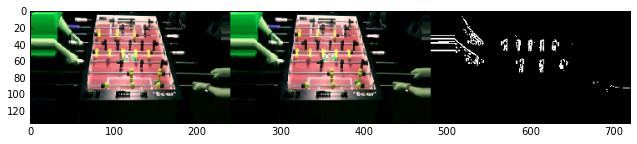

(134, 240, 3)
(134, 720, 3)


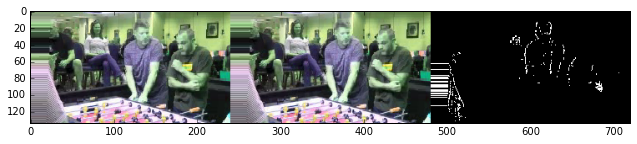

(134, 240, 3)
(134, 720, 3)


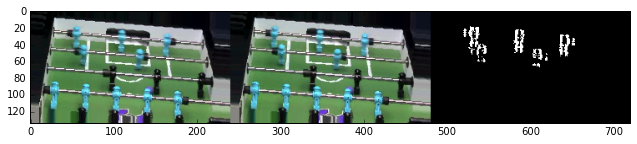

(134, 240, 3)
(134, 720, 3)


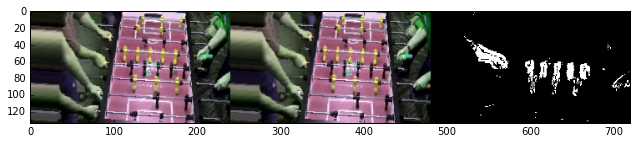

(134, 240, 3)
(134, 720, 3)


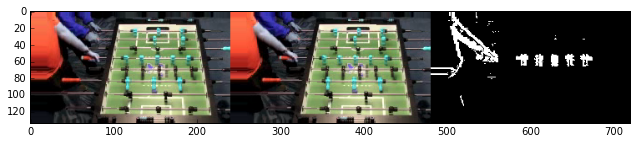

(134, 240, 3)
(134, 720, 3)


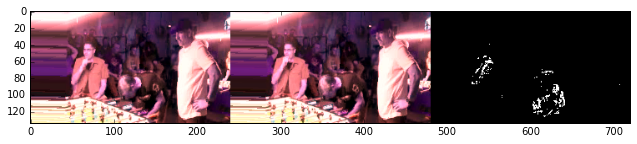

(134, 240, 3)
(134, 720, 3)


(134, 240, 3)
(134, 720, 3)


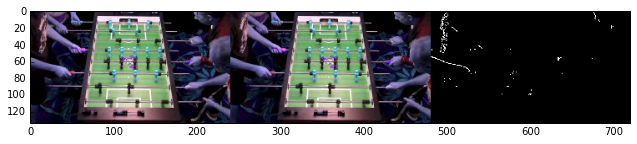

(134, 240, 3)
(134, 720, 3)


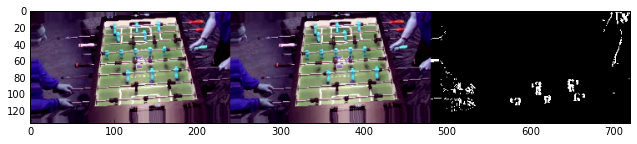

(134, 240, 3)
(134, 720, 3)


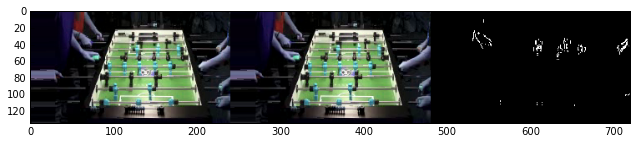

(134, 240, 3)
(134, 720, 3)


(134, 240, 3)
(134, 720, 3)


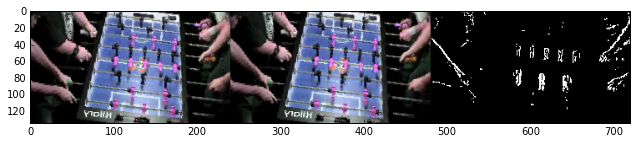

(134, 240, 3)
(134, 720, 3)


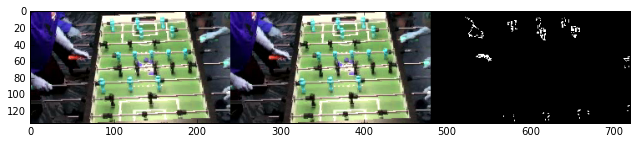

(134, 240, 3)
(134, 720, 3)


(134, 240, 3)
(134, 720, 3)


(134, 240, 3)
(134, 720, 3)


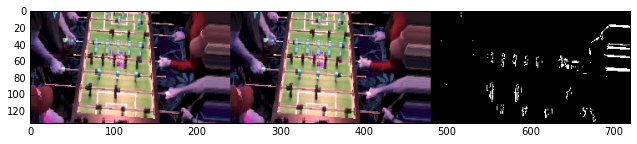

(134, 240, 3)
(134, 720, 3)


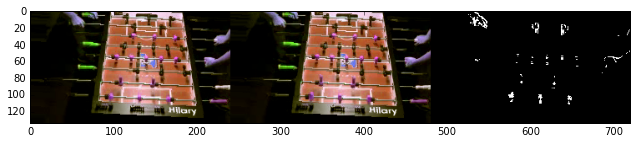

(134, 240, 3)
(134, 720, 3)


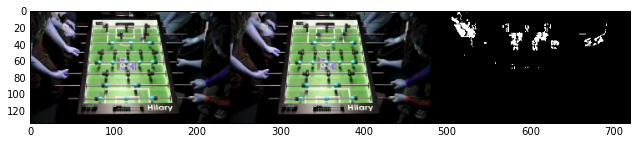

(134, 240, 3)
(134, 720, 3)


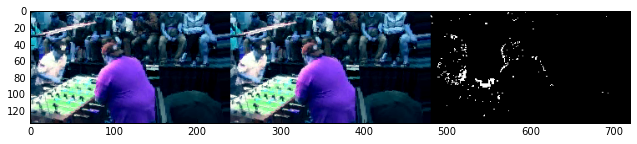

In [5]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

# View the first few frames
for k in range(20):
    data = training.get_next_frame()
    print(data["frame0"].shape)
    frames = np.concatenate((data["frame0"],data["frame1"],data["frame2"]),1)
    print(frames.shape)
    fig, ax = plt.subplots(figsize=(18, 2))
    plt.imshow(frames)
    plt.show()

In [6]:
# https://stanford.edu/~shervine/blog/keras-generator-multiprocessing.html
class threadsafe_iter(object):
  """
    Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
  def __init__(self, it):
      self.it = it
      self.lock = threading.Lock()

  def __iter__(self):
      return self

  def __next__(self):
      with self.lock:
          return self.it.__next__()

# https://stanford.edu/~shervine/blog/keras-generator-multiprocessing.html
def threadsafe_generator(f):
  """
    A decorator that takes a generator function and makes it thread-safe.
    """
  def g(*a, **kw):
      return threadsafe_iter(f(*a, **kw))
  return g


# Define our training and validation iterators
@threadsafe_generator
def TrainGen(training):
    while True:
        data = training.get_next_frame()
        if data is not None:
            frame0 = data["frame0"]
            frame1 = data["frame1"]
            frame2 = data["frame2"]
            
            while frame0 is not None:
                yield (frame0, frame1, frame2)
                data = training.get_next_frame()
                if data is not None:
                    frame0 = data["frame0"]
                    frame1 = data["frame1"]
                    frame2 = data["frame2"]
                else:
                    frame0 = None
                    frame1 = None
                    frame2 = None
                
             
# Generators for training the position
@threadsafe_generator
def TrainBatchGen(batch_size, training):
    gen = TrainGen(training)
    while True:
        # Build the next batch
        batch_frame0s = np.zeros(shape=(batch_size, 134, 240, 3), dtype=np.float32)
        batch_frame1s = np.zeros(shape=(batch_size, 134, 240, 3), dtype=np.float32)
        # (None, 128, 224, 3)
        # ((top_crop, bottom_crop), (left_crop, right_crop))
        # Crop 6 from top, crop 16 from left
        batch_frame2s = np.zeros(shape=(batch_size, 128, 224, 3), dtype=np.float32)
        for i in range(batch_size):
            (frame0, frame1, frame2) = next(gen)
            batch_frame0s[i,:,:,:] = frame0
            batch_frame1s[i,:,:,:] = frame1
            batch_frame2s[i,:,:,:] = frame2[6:,16:]
            
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield ([batch_frame0s, batch_frame1s], batch_frame2s)
        #pp.pprint("Yielded batch")

                
             
# Generators for training the position
@threadsafe_generator
def ValidationBatchGen(batch_size, validation):
    gen = TrainGen(validation)
    while True:
        # Build the next batch
        batch_frame0s = np.zeros(shape=(batch_size, 134, 240, 3), dtype=np.float32)
        batch_frame1s = np.zeros(shape=(batch_size, 134, 240, 3), dtype=np.float32)
        batch_frame2s = np.zeros(shape=(batch_size, 128, 224, 3), dtype=np.float32)
        for i in range(batch_size):
            (frame0, frame1, frame2) = next(gen)
            batch_frame0s[i,:,:,:] = frame0
            batch_frame1s[i,:,:,:] = frame1
            batch_frame2s[i,:,:,:] = frame2[6:,16:]
            
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield ([batch_frame0s, batch_frame1s], batch_frame2s)
        #pp.pprint("Yielded batch")
        
    
    
        
    


In [7]:
from keras.losses import mean_squared_error

# Utilities for plotting the result and training
def plot_validate(generator, model, count, name):   
    errors_true = []
    errors_prediction = []
    
    
    while len(errors_true) < count:
        
        (frames, outputs_true) = next(generator)
        outputs_predicted = model.predict(frames, batch_size=frames[0].shape[0], verbose=0)
        
        for i in range(outputs_predicted.shape[0]):
            if len(errors_true) < 5:
                # View the first set
                inputs = np.concatenate((frames[0][i,6:,16:],frames[1][i,6:,16:]),1)
                fig, ax = plt.subplots(figsize=(45, 8))
                h = plt.imshow(inputs)
                plt.title( 'Frame0,Frame1' )
                plt.show()

                results = np.concatenate((outputs_true[i],outputs_predicted[i]),1)
                fig, ax = plt.subplots(figsize=(45, 8))
                h = plt.imshow(results)
                plt.title( 'True,Predicted' )
                plt.show()
            
            # Calculate the actual difference and predicted image difference
            zero_frame = np.zeros_like(frames[1][i,6:,16:])
            mse_true = ((outputs_true[i] - zero_frame) ** 2).mean()
            mse_predicted = ((outputs_true[i] - outputs_predicted[i]) ** 2).mean()
            #mse_true = K.eval(K.mean(mean_squared_error(outputs_true[i], frames[1][i,6:,16:])))
            #mse_predicted = K.eval(K.mean(mean_squared_error(outputs_true[i], outputs_predicted[i])))
            errors_true.append(mse_true)
            errors_prediction.append(mse_predicted)
    
    
    true, predicted = zip(*sorted(zip(errors_true, errors_prediction)))
    l1, = plt.plot(range(len(errors_true)), true, label="Error baseline by assuming no changes")
    l2, = plt.plot(range(len(errors_true)), predicted, label="Predicted error to next frame")
    plt.legend(handles=[l1, l2])
    plt.show()

#plot_validate(ValidationBatchGen(batch_size, validation), frame_prediction_model, 5, "Epoch validation results %i" % epoch)



'Input shape without batches:'
(134, 240, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 134, 240, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 134, 240, 40)      1120      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 134, 240, 40)      14440     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 134, 120, 40)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 134, 120, 40)      14440     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 134, 120, 40)      14440     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (N

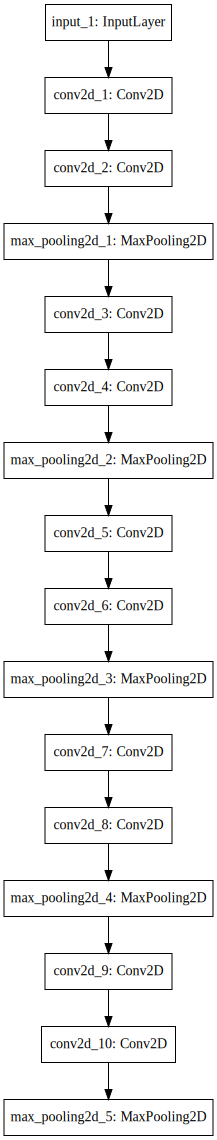

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
frame0 (InputLayer)              (None, 134, 240, 3)   0                                            
____________________________________________________________________________________________________
frame1 (InputLayer)              (None, 134, 240, 3)   0                                            
____________________________________________________________________________________________________
model_1 (Model)                  [(None, 8, 7, 40), (N 131080      frame0[0][0]                     
                                                                   frame1[0][0]                     
____________________________________________________________________________________________________
concatenate_1 (Concatenate)      (None, 8, 7, 80)      0           model_1[1][0]           

In [ ]:
from keras.models import Sequential
from keras.layers import *
from keras.models import Model
from keras.utils import plot_model



image_height       = 134
image_width        = 240
image_channels     = 3

# Model options
batch_size = 10
lstm_output_size = 300
cnn_kernel_count = 40

# Build an hourglass model. Notes on the model structure:
# Two camera frames as input.
# frame0 -> Conv and pooling until embedding (shared convoluations to both frame0 and frame1)
# frame1 -> Conv and pooling until embedding
# Conv both paths together
# Residual upsampling of frame1 until original size
# Pixel-wise error to frame2 as loss

pp.pprint("Input shape without batches:")
pp.pprint((image_height, image_width, image_channels))

# Used to give fixed names to the layers for transferring the model
conv_num = 0 
pool_num = 0
dense_num = 0


# Create the embedding module, the same model runs both frames
frame_in = Input(shape=(image_height, image_width, image_channels,))
x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(frame_in)
x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
res0 = x

x = MaxPooling2D((1, 2))(x)

x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
res1 = x

x = MaxPooling2D((2, 2))(x)



x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
res2 = x
x = MaxPooling2D((2, 2))(x)



x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
res3 = x
x = MaxPooling2D((2, 2))(x)



x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
res4 = x
embedding = MaxPooling2D((2, 2))(x)


foosball_embedding = Model(frame_in, [embedding, res0, res1, res2, res3, res4])
foosball_embedding.summary()

from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot
display(SVG(model_to_dot(foosball_embedding).create(prog='dot', format='svg')))

# Create the frame embeddings
frame0 = Input(shape=(image_height, image_width, image_channels,),
              name="frame0")
frame1 = Input(shape=(image_height, image_width, image_channels,),
              name="frame1")
[embedding_a, res0_a, res1_a, res2_a, res3_a, res4_a] = foosball_embedding(frame0)
[embedding_b, res0_b, res1_b, res2_b, res3_b, res4_b] = foosball_embedding(frame1)
concatenated = keras.layers.concatenate([embedding_a, embedding_b])
x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(concatenated)
x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)

# Create the upsampling stages, feeding residual from frame1
x = UpSampling2D(size=(2, 2), data_format=None)(x)
# [(None, 16, 14, 40), (None, 16, 15, 40)]
res4_b = Cropping2D(cropping=(((0, 0), (1, 0))), data_format=None)(res4_b)
x = keras.layers.concatenate([x, res4_b])
x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)

x = UpSampling2D(size=(2, 2), data_format=None)(x)
# [(None, 32, 28, 40), (None, 32, 30, 40)]
res3_b = Cropping2D(cropping=(((1, 0), (2, 0))), data_format=None)(res3_b)
x = keras.layers.concatenate([x, res3_b])
x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)

x = UpSampling2D(size=(2, 2), data_format=None)(x)
# (None, 64, 60, 40), (None, 67, 60, 40)
res2_b = Cropping2D(cropping=(((3, 0), (4, 0))), data_format=None)(res2_b)
x = keras.layers.concatenate([x, res2_b])
x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)

x = UpSampling2D(size=(2, 2))(x)
# [(None, 128, 120, 40), (None, 134, 120, 40)]
res1_b = Cropping2D(cropping=(((6, 0), (8, 0))), data_format=None)(res1_b)
x = keras.layers.concatenate([x, res1_b])
x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)


x = UpSampling2D(size=(1, 2))(x)
# 
res0_b = Cropping2D(cropping=(((6, 0), (16, 0))), data_format=None)(res0_b)
x = keras.layers.concatenate([x, res0_b])
x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)


# RGB output as three channels
x = Conv2D(3, (1, 1),
           padding = "same",
           activation = "relu",)(x)

frame_prediction_model = Model([frame0, frame1], [x])

# For a multi-class classification problem
frame_prediction_model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002),
#model.compile(optimizer=keras.optimizers.adam(),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])


frame_prediction_model.summary()

#plot_model(frame_prediction_model, to_file='model.png')
from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot
display(SVG(model_to_dot(frame_prediction_model).create(prog='dot', format='svg')))

# Train the model to predict the future position. This is the control signal to the robot AI
WEIGHTS_FNAME = '.\\Goalie3Frames\\weights_%i.hdf'
MODELS_FNAME = '.\\Goalie3Frames\\models_%i.h5'

Batch size 10: 500 training batches, 50 validation batches
Epoch 1/1
500/500 [==============================] - 514s - loss: 0.0334 - mean_squared_error: 0.0334 - val_loss: 0.0338 - val_mean_squared_error: 0.0338


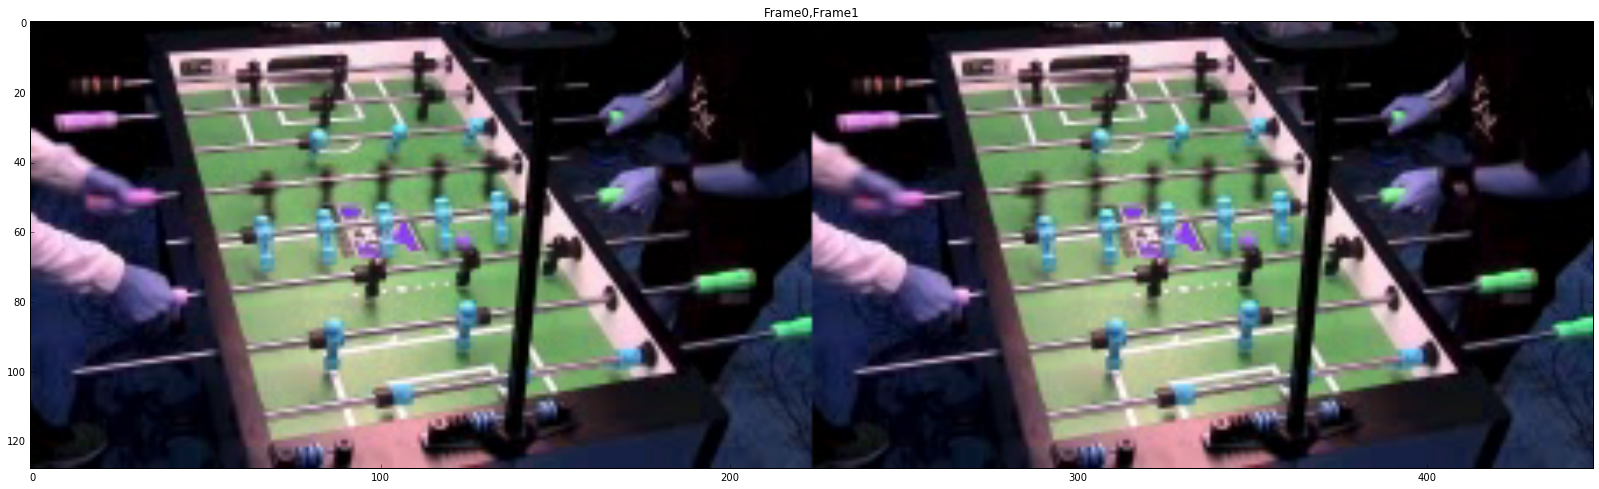

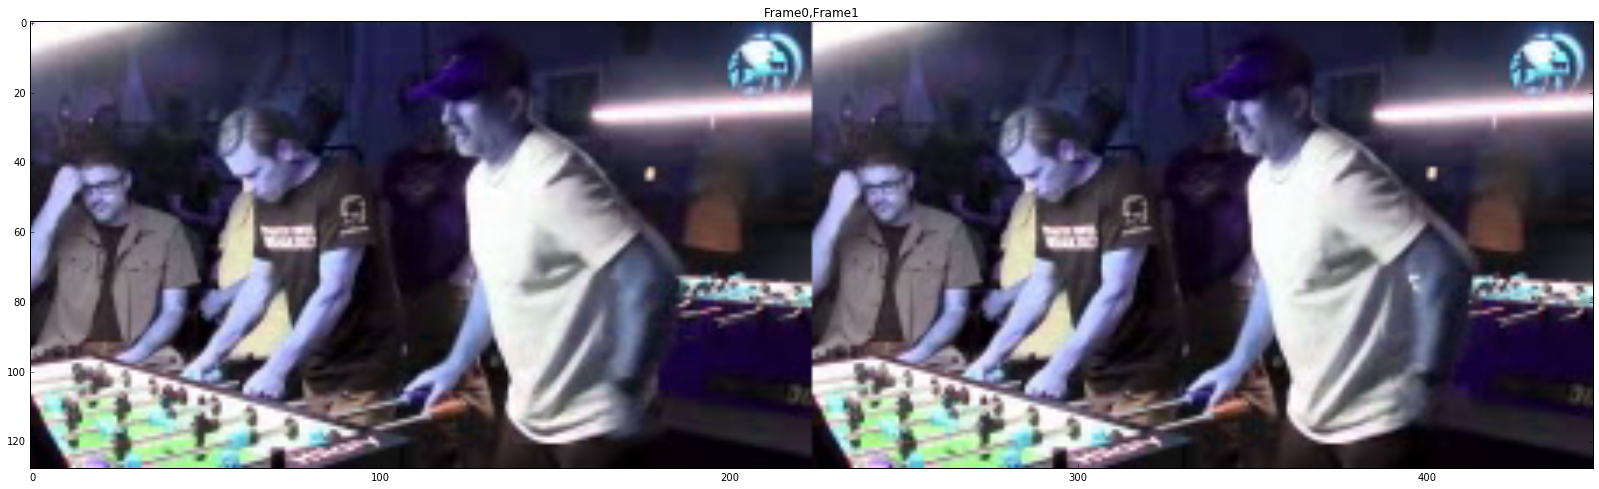

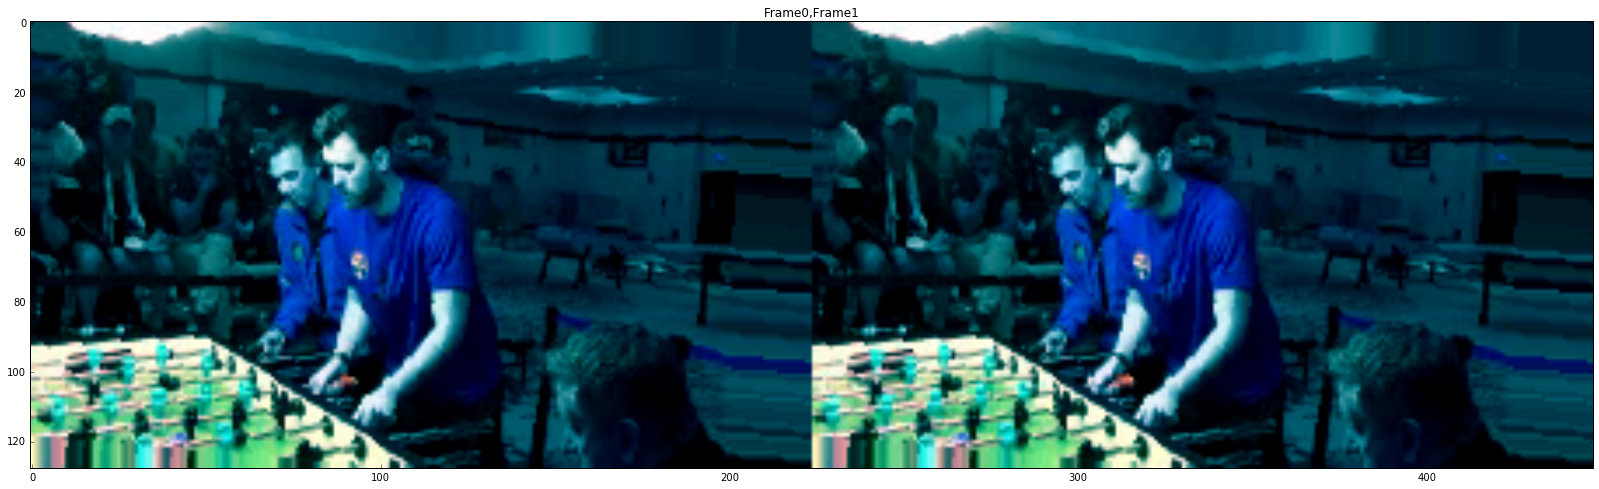

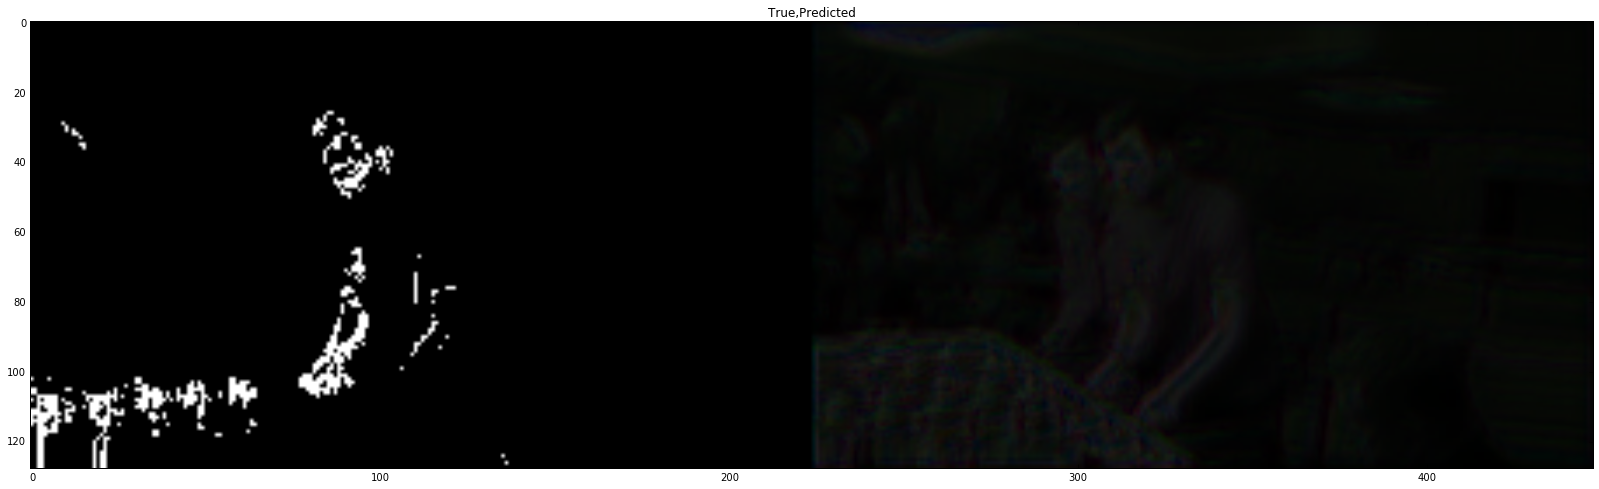

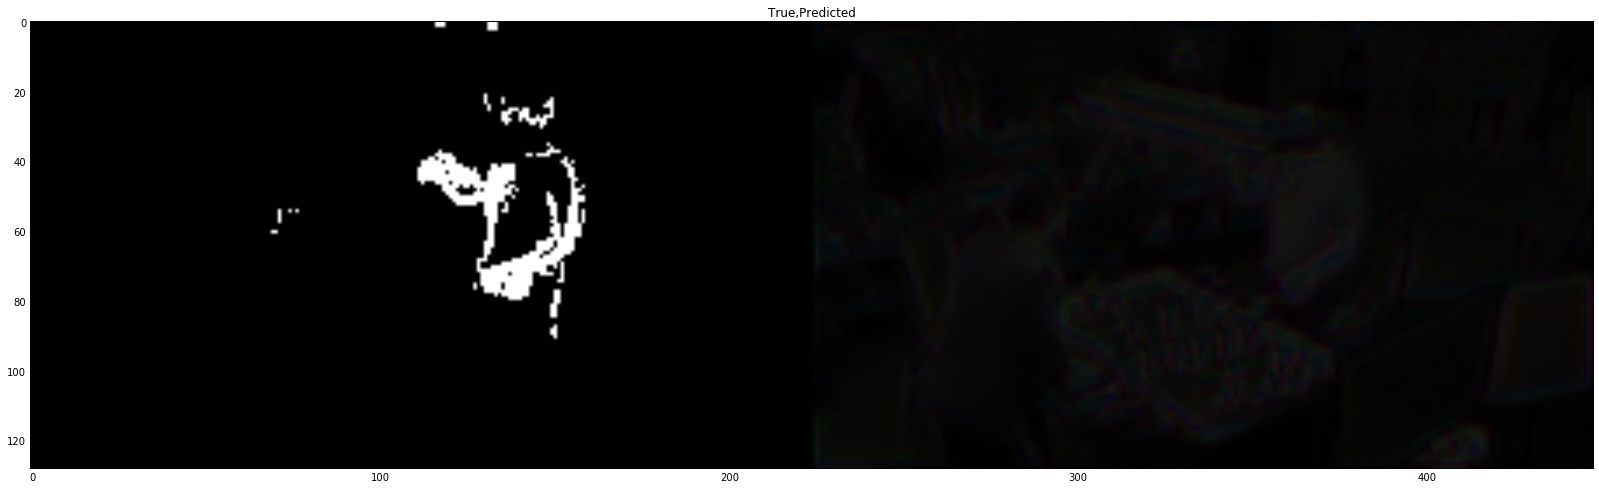

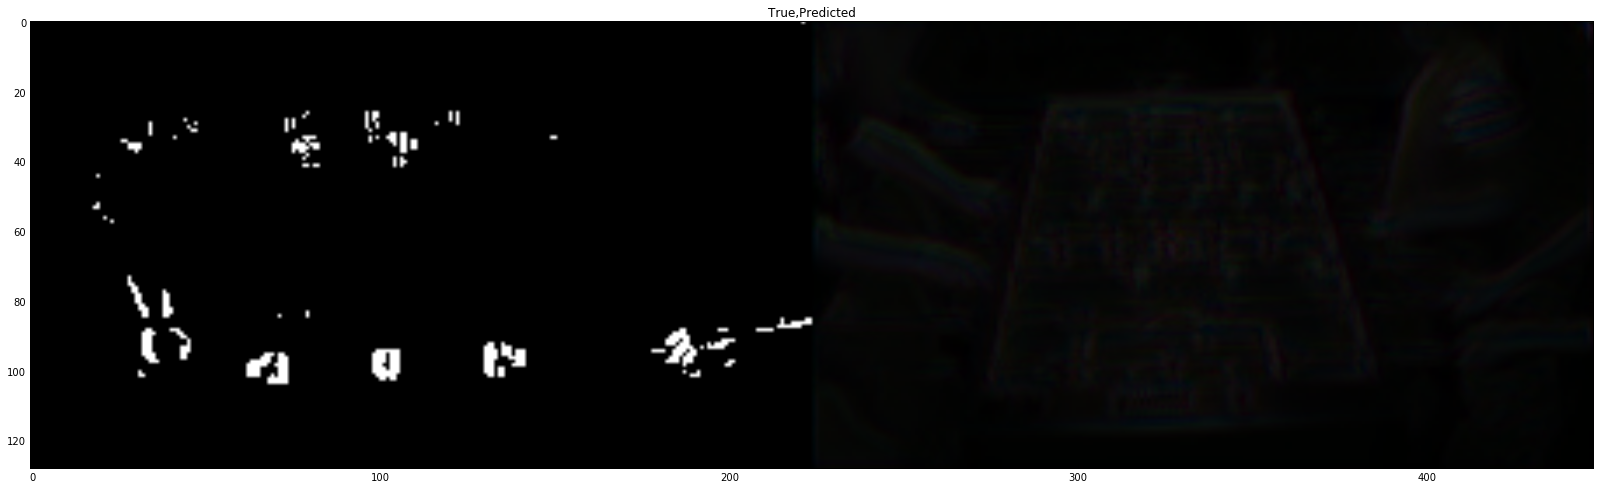

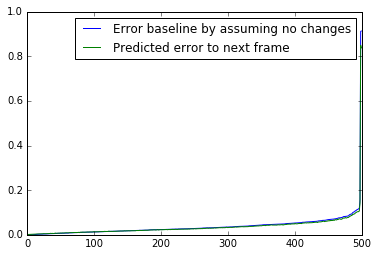

Wrote model to .\Models\weights_1.hdf
Epoch 2/2
 24/500 [>.............................] - ETA: 606s - loss: 0.0332 - mean_squared_error: 0.0332

In [ ]:
# For a multi-class classification problem
frame_prediction_model.compile(optimizer=keras.optimizers.RMSprop(lr=0.000005),
#model.compile(optimizer=keras.optimizers.adam(),
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

# Was ran on the above simple model, not pre-trained Inceptionv3 run.
epoch = 0
#batches_validation_per_epoch = 50
#batches_training_per_epoch = 400
batch_size = 10
batches_training_per_epoch = 500
batches_validation_per_epoch = 50
print("Batch size %i: %i training batches, %i validation batches" % (batch_size, batches_training_per_epoch, batches_validation_per_epoch) )
WEIGHTS_FNAME = '.\\Models\\weights_%i.hdf'
MODELS_FNAME = '.\\Models\\models_%i.h5'

for i in range(500):
    frame_prediction_model.fit_generator(
        TrainBatchGen(batch_size, training=training),
        batches_training_per_epoch,
        epochs=epoch+1,
        verbose=1,
        callbacks=None,
        class_weight=None,
        max_q_size=50,
        workers=50,
        validation_data=ValidationBatchGen(batch_size, validation),
        validation_steps = batches_validation_per_epoch,
        pickle_safe=False,
        initial_epoch=epoch)
    
    epoch += 1
    
    # Plot occasional validation data plot
    if i % 10 == 0:
        plot_validate(ValidationBatchGen(batch_size, validation), frame_prediction_model, 500, "Epoch validation results %i" % epoch)
    
    # Save the model
    frame_prediction_model.save_weights(WEIGHTS_FNAME % epoch)
    frame_prediction_model.save(MODELS_FNAME % epoch)
    print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)



In [19]:
plot_validate(ValidationBatchGen(batch_size, validation), frame_prediction_model, 500, "Epoch validation results %i" % epoch)

TypeError: list indices must be integers or slices, not tuple